In [28]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [29]:
img_ = cv2.imread('uttower_left.JPG')
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
img = cv2.imread('uttower_right.JPG')
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [30]:
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [31]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

In [32]:
# Apply ratio test
good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)
matches = np.asarray(good)

[[ 1.29844369e+00 -7.28812387e-02 -5.74509670e+02]
 [ 1.69257596e-01  1.22127305e+00 -1.68398835e+02]
 [ 2.78210585e-04  2.39738846e-05  1.00000000e+00]]


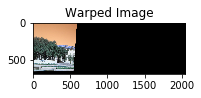

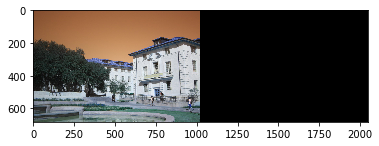

In [36]:

if len(matches[:,0]) >= 4:
    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)

    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    print(H)
else:
    raise AssertionError("Can't find enough keypoints.")

dst = cv2.warpPerspective(img_,H,(img.shape[1] + img_.shape[1], img.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
plt.show()
plt.figure()
dst[0:img.shape[0], 0:img.shape[1]] = img
cv2.imwrite('output.jpg',dst)
plt.imshow(dst)
plt.show()


100%|██████████| 1000/1000 [00:17<00:00, 58.48it/s]


@@@ 40


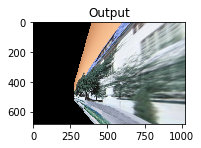

In [37]:
from tqdm import tqdm
for i in tqdm(range(1000)):
	pts = []
	ind = []
	H_matrix = []
	j=[]
	while(len(ind)!=4):
		random_index = randrange(0,len(matches))
		if random_index not in ind:
			pts.append(matches[random_index])
			ind.append(random_index)
	src = np.float32([ kp1[m[0].queryIdx].pt for m in pts ]).reshape(-1,1,2)
	dst = np.float32([ kp2[m[0].trainIdx].pt for m in pts ]).reshape(-1,1,2)
	H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 3.0)
	H_matrix.append(H)
	count=0
	inliers = []
	
	for i in matches:
		c1 = i[0].trainIdx
		c2 = i[0].queryIdx
		count+=1
		#print(count)
		
		p=[]
		p.append(kp1[c2].pt[0])
		p.append(kp1[c2].pt[1])
		p.append(1)
		p = np.array(p)
		p1 = np.matmul(H,p)
		p1 = np.array([p1[0]/float(p1[2]),p1[1]/float(p1[2])])
		
		p2=[]
		p2.append(kp2[c1].pt[0])
		p2.append(kp2[c1].pt[1])
		p2 = np.array(p2)
		#print(p2)
		#print("#####")
		d = np.linalg.norm(p1-p2)
		#print(d)
		
		if d<4:
			j.append(i)
	inliers.append(j)		
			
				
max_inlier = max(inliers, key=len)
print ("@@@ "+str(len(max_inlier)))
max_inlier_index = inliers.index(max_inlier)
best_H = H_matrix[max_inlier_index]
(a,b)=img1.shape
transformed_image = cv2.warpPerspective(img_, best_H,(b,a) )			
plt.subplot(122),plt.imshow(transformed_image),plt.title('Output')
plt.show()